In [1]:
import h5py
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import tensorflow_probability as tfp
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
#import data set
import numpy as np
mnist = tf.keras.datasets.mnist
import random
from tensorboard.plugins.hparams import api as hp
import datetime
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
from sklearn import ensemble

import random
from sklearn.model_selection import train_test_split
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
tfd = tfp.distributions
from photoz_utils import *

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
    
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
import neptune.new as neptune
#import photoz data:
tfd = tfp.distributions
#from google.colab import files

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

import h5py
photozdata = h5py.File('../../data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected.hdf5', 'r')


spectro_z = np.asarray(photozdata["specz_redshift"])
col1 = np.asarray(photozdata["g_cmodel_mag"])
col2 = np.asarray(photozdata["r_cmodel_mag"])
col3 = np.asarray(photozdata["i_cmodel_mag"])
col4 =np.asarray(photozdata["z_cmodel_mag"])
col5 = np.asarray(photozdata["y_cmodel_mag"])
specz_err = np.asarray(photozdata["specz_redshift_err"])
gmag_err = np.asarray(photozdata["g_cmodel_magsigma"])
ymag_err = np.asarray(photozdata["y_cmodel_magsigma"])

photodata = {'col1':col1,
             'col2':col2,
             'col3':col3,
             'col4':col4,
             'col5':col5,
             'specz_err': specz_err,
             'gmag_err':gmag_err,
             'ymag_err':ymag_err,
             'specz':spectro_z
}


df = pd.DataFrame(photodata)
photodata = df

photodata.replace(-99., np.nan, inplace=True)
photodata.replace(-99.9, np.nan, inplace=True)
photodata.replace(np.inf, np.nan, inplace=True)
photodata= photodata.dropna(how='any')
specz_err = photodata['specz_err']
spectro_z = photodata['specz']
gmag_err = photodata['gmag_err']
ymag_err = photodata['ymag_err']
photodata = photodata.drop("specz", axis=1)
photodata = photodata.drop("specz_err", axis =1)
photodata = photodata.drop("gmag_err", axis =1)
photodata = photodata.drop("ymag_err", axis =1)

print(len(photodata))
photodata1 = photodata
#normalize
photodata = min_max_scaler.fit_transform(photodata)

photodata = min_max_scaler.fit_transform(photodata)
photozdata.close()

indices = np.arange(len(spectro_z))

x_train ,x_test,y_train,y_test, idx_train,idx_test = train_test_split(photodata,spectro_z, indices, test_size=0.20)



Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
286401


In [27]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    L = 1 - 1.0 / denominator
    return L


def calculate_conv_outlier_rate2(z_photo,z_spec):

# This function calculate the conventional outlier rate. 

    outliers = []
    outliers_bayesian = []
    outlier_index_bayesian = []
    outlier_index = []
    for i in range(0,len(z_spec)):


        #outliers.append((abs(photoz[i] - y_test_original[i]))/(1+y_test_original[i]))
        outliers.append((abs(z_photo[i] - z_spec[i]))/(1+z_spec[i]))
        if outliers[i] > 0.15:
            outlier_index.append(i)
    
        outliers_bayesian.append((abs(z_photo[i] - z_spec[i]))/(1+z_spec[i]))
        if outliers_bayesian[i] > 0.15:
            outlier_index_bayesian.append(i)
            
    outlier_rate_conv = len(outlier_index_bayesian)/len(z_spec) 
    
    return outlier_rate_conv


def calculate_bayesian_outlier_rate2(z_photo,z_spec,zpdf_std):

# This function calculate the conventional outlier rate. 

    outliers = []
    outliers_bayesian = []
    outlier_index_bayesian = []
    for i in range(0,len(z_spec)):


        outliers_bayesian.append((abs(z_photo[i] - z_spec[i])-zpdf_std[i][0])/(1+z_spec[i]))
        if outliers_bayesian[i] > 0.15:
            outlier_index_bayesian.append(i)
            
    bayesian_outlier_rate = len(outlier_index_bayesian)/len(z_spec) 
    
    return bayesian_outlier_rate


indices = np.arange(len(spectro_z))

x_train ,x_test,y_train,y_test, idx_train,idx_test = train_test_split(photodata,spectro_z, indices, test_size=0.20)


x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5) # 

    
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_original = y_test


x_train = np.array(x_train)

x_test = np.array(x_test)

x_val = np.array(x_val)
y_val = np.array(y_val)



def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= + 10e-4*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])


def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])


def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([20,40,60,80,100]))
HP_NUM_EPOCHS = hp.HParam('num_epochs', hp.Discrete([500,1000]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'RMSprop']))

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([40,60,80,120,160]))
HP_NUM_EPOCHS = hp.HParam('num_epochs', hp.Discrete([500,750,1000,1250,1500]))
HP_NUM_EPOCHS = hp.HParam('num_epochs', hp.Discrete([1000]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([200]))

METRIC_ACCURACY = keras.metrics.RootMeanSquaredError()


checkpoint_path = 'evan_checkpoints/cp7.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='loss',
                                                 verbose=1,
                                                 save_freq = 100,
                                                 save_best_only=True)


params = {"lr": 0.0005, "epochs": 20000}


session_num = 0
coverage_list_mean = []
coverage_list_std = []
z_delta_div_uncertainty_list = []
z_delta_div_uncertainty = []
num_units = 200
hparams = {
  HP_NUM_UNITS: num_units
}
input_ = tf.keras.layers.Input(shape=x_train.shape[1:])
hidden1 = tf.keras.layers.Dense(200, activation="relu")(input_)
hidden2 = tf.keras.layers.Dense(200, activation="relu")(hidden1)
hidden3 = tf.keras.layers.Dense(200, activation="relu")(hidden2)
hidden4 = tf.keras.layers.Dense(200, activation="relu")(hidden3)

concat = tf.keras.layers.Concatenate()([input_, hidden4])
distribution_params = tf.keras.layers.Dense(units=2)(concat)
output = tfp.layers.IndependentNormal(1)(distribution_params)
model = tf.keras.Model(inputs=[input_], outputs=[output])


optimizer = tf.keras.optimizers.Adam(learning_rate=params["lr"])
model.compile(optimizer=optimizer,  loss=calculate_loss,metrics=[keras.metrics.RootMeanSquaredError()])

print("Start training the model...")
_, rmse = model.evaluate(x_train,y_train, verbose=1)
print(f"Train RMSE: {round(rmse, 5)}")

print("Evaluating model performance...")
_, rmse = model.evaluate(x_test, y_test,verbose=1)
print(f"Test RMSE: {round(rmse, 5)}")

model.summary()

#for tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(x_train,y_train,epochs=params["epochs"],batch_size = 100000, shuffle = True,verbose=1,validation_data=(x_test,y_test), callbacks=[
tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1),  # log metrics
hp.KerasCallback(log_dir, hparams),cp_callback])

coverage_1sigma_list = []
outlier_list1 = []
outlier_list2 = []
outlier_list3 = []
bayesian_outlier_list = []
mean_rms_i_list = []
std_rms_i_list = []
prediction_mean_list = []
prediction_stdv_list = []
delta_z_list = []
delta_z_list2 = []
summed_rms_list = []
loop_size = 1

coverage_list_per_gal= []


for_coverage_list_per_gal = [0] * len(y_test)


z_delta_div_uncertainty = []




Start training the model...
7160/7160 [==============================] - 6s 870us/step - loss: 0.7936 - root_mean_squared_error: 1.1258
Train RMSE: 1.12582
Evaluating model performance...
895/895 [==============================] - 1s 878us/step - loss: 0.7939 - root_mean_squared_error: 1.1318
Test RMSE: 1.13181
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 200)          1200        input_10[0][0]                   
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 200)          40200       dense_45[0]

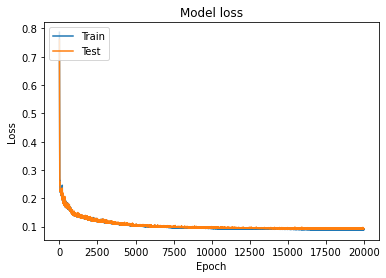

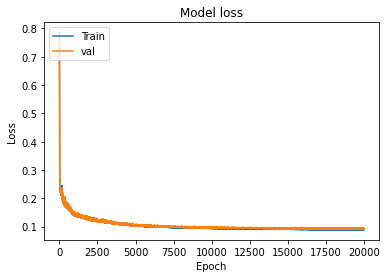

mean_summed_rms_list 0.00020049934
std_summed_rms_list 0.0
mean_of_rms_i_means_list 0.032480303
std_of_rms_i_means_list 0.0
std_of_std_of_rms_i_list 0.0
% of spec-z within 1 stdev of the prediction mean : 0.02
mean 1 sigma coverage with 100 trials :  0.017
stdev of 1 sigma coverage with 100 trials:  0.0


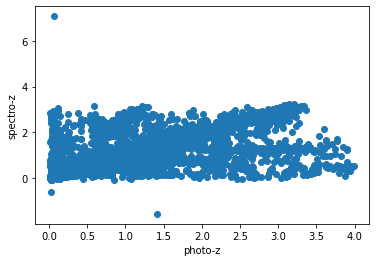

% correct:  0.23044692737430167
number of outliers:  1808  out of  28640
% of outliers:  6.312849162011173
number of catastrophic outliers:  159  out of  28640
% of catastrophic outliers:  0.0055516759776536315
number of bayesian outliers:  1808  out of  28640
% of bayesian outliers:  6.312849162011173
number of bayesian catastrophic outliers:  159  out of  28640
% of bayesian catastrophic outliers:  0.0055516759776536315
mean individual galaxy RMS 0.05742146
stdev individual galaxy RMS 0.17083058
Summed RMS:  [0.18022162]


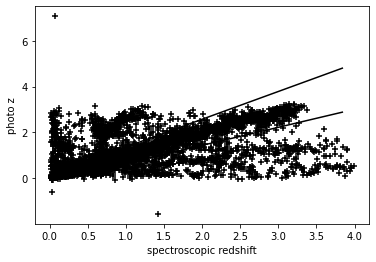

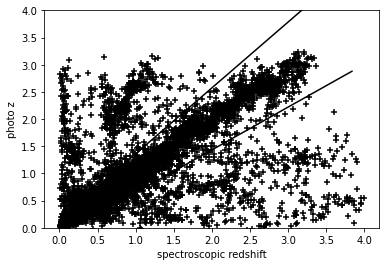

coverage_list_mean:  [0.017]
coverage_list_std:  [0.0]
mean of mean stdv of zPDF after 500 determinations:  8.406396252743548e-06
mean of stdv of zPDF stdv after 500 determinations:  0.0
mean of std of zPDF means after 500 determinations:  0.0
mean of delta_z (specz-photz) mean after 500 determinations:  0.006261038
mean of delta_z (specz-photz) stdv after 500 determinations:  0.0
average outlier rate after 500 determinations: 0.06312849162011173
average bayesian outlier rate after 500 determination:  0.06312849162011173


In [28]:

#load weights here if you want to evaluate a checkpoint:
model.load_weights('evan_checkpoints/cp7.ckpt')

#otherwise just continue:
evaluated_model = model(x_test)
prediction_mean = (evaluated_model.mean()).numpy().tolist()

prediction_stdv = (evaluated_model.stddev()).numpy()
#prediction_stdv = np.std((model(x_test)*bin_size))
# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()
#delta_z_list.append(np.array(y_test) - np.array(prediction_mean))
prediction_mean_list.append(prediction_mean)
prediction_stdv_list.append(prediction_stdv)
predictions = model.predict(x_test)
outlier_list1.append(calculate_conv_outlier_rate2(prediction_mean,y_test))

num_within = 0
for idx in range(len(y_test)):
    if abs(prediction_mean[idx][0] - y_test[idx]) < prediction_stdv[idx][0]:
      for_coverage_list_per_gal[idx] = for_coverage_list_per_gal[idx] + 1
      num_within = num_within+1

coverage_1sigma_list.append(round(num_within/len(y_test)*100,3))
#coverage_list_per_gal.append(for_coverage_list_per_gal)


predictions = model.predict(x_test)
photoz = []
outlier_list2.append(calculate_conv_outlier_rate2(predictions,y_test))
outlier_list3.append(calculate_bayesian_outlier_rate2(predictions,y_test,prediction_stdv))
delta_list_temp = []
for i in range(0,len(y_test)):
    photoz.append(predictions[i])
    delta_list_temp.append(y_test[i]-predictions[i])

delta_z_list2.append(delta_list_temp)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','val'],loc='upper left')
plt.show()




photoz_2 = predictions
RMS_i = []
for i in range(0,len(y_test)):
  z_delta_div_uncertainty.append((photoz[i]-y_test_original[i])/prediction_stdv[i][0])
  rms = ((photoz[i]-y_test_original[i])/(1+y_test_original[i]))**2
  RMS_i.append(rms)

z_delta_div_uncertainty_list.append(z_delta_div_uncertainty)
mean_rms_i = np.mean(RMS_i)
mean_rms_i_list.append(mean_rms_i)
std_rms_i = np.std(RMS_i)
std_rms_i_list.append(std_rms_i)

####calculate summed RMS
rms_sum = 0
for i in range(0,len(y_test)):
  rms_sum = rms_sum + RMS_i[i] 

  rms_sum = np.sqrt(rms_sum/len(y_test))

#print("Summed RMS: ", rms_sum)
summed_rms_list.append(rms_sum)



mean_summed_rms_list = np.mean(summed_rms_list)
std_summed_rms_list = np.std(summed_rms_list)

mean_of_rms_i_means_list = np.mean(mean_rms_i_list)
std_of_rms_i_means_list = np.std(mean_rms_i_list)

std_of_std_of_rms_i_list = np.std(std_rms_i_list)


print("mean_summed_rms_list",mean_summed_rms_list)
print("std_summed_rms_list",std_summed_rms_list)
print("mean_of_rms_i_means_list",mean_of_rms_i_means_list)
print("std_of_rms_i_means_list",std_of_rms_i_means_list)
print("std_of_std_of_rms_i_list",std_of_std_of_rms_i_list)





print("% of spec-z within 1 stdev of the prediction mean :", round(num_within/len(y_test) * 100.0,2))

mean_coverage_1sigma_list = np.mean(coverage_1sigma_list)
std_coverage_1sigma_list = np.std(coverage_1sigma_list)

print("mean 1 sigma coverage with 100 trials : ", mean_coverage_1sigma_list)
print("stdev of 1 sigma coverage with 100 trials: ", std_coverage_1sigma_list)

coverage_list_mean.append(mean_coverage_1sigma_list)
coverage_list_std.append(std_coverage_1sigma_list)



#now calc coverage per gal
final_per_gal_coverage = []
for i in range(0,len(y_test)):
  final_per_gal_coverage.append(100*for_coverage_list_per_gal[i]/loop_size)

coverage_percent_diff = []
for i in range(0,len(coverage_list_mean)):
  coverage_percent_diff.append(-(68-coverage_list_mean[i])/68)




predictions = model.predict(x_test)
np.argmax(predictions[0])
photoz = []

for i in range(0,len(y_test)):
    photoz.append(predictions[i])

plt.scatter(y_test_original,photoz)
#plt.title('Photo-z determination')
plt.ylabel('spectro-z')
plt.xlabel('photo-z')
plt.show()



num_correct = 0
outliers = []
outliers_bayesian = []
outlier_index = []
outlier_index_bayesian = []
cat_outlier_index_bayesian = []
cat_outlier_index = []
#y_test = y_test * bin_size
for i in range(0,len(y_test)):

    if abs(photoz[i] - (y_test[i])) < 0.0001:

        num_correct = num_correct + 1
        
    outliers.append((abs(photoz[i] - y_test_original[i]))/(1+y_test_original[i]))
    outliers_bayesian.append((abs(photoz[i] - y_test_original[i]) - prediction_stdv[i][0])/(1+y_test_original[i]))

    if outliers[i] > 0.15:
            outlier_index.append(i)


    if outliers[i] > 1:
            cat_outlier_index.append(i)
            
    if outliers_bayesian[i] > 0.15:
            outlier_index_bayesian.append(i)


    if outliers_bayesian[i] > 1:
            cat_outlier_index_bayesian.append(i)



print("% correct: ", 100.0*num_correct/len(y_test))
print("number of outliers: ", len(outlier_index), " out of ", len(y_test))
print("% of outliers: ", 100.0*len(outlier_index)/len(y_test))
print("number of catastrophic outliers: ", len(cat_outlier_index), " out of ", len(y_test))
print("% of catastrophic outliers: ", len(cat_outlier_index)/len(y_test))

print("number of bayesian outliers: ", len(outlier_index_bayesian), " out of ", len(y_test))
print("% of bayesian outliers: ", 100.0*len(outlier_index_bayesian)/len(y_test))
print("number of bayesian catastrophic outliers: ", len(cat_outlier_index_bayesian), " out of ", len(y_test))
print("% of bayesian catastrophic outliers: ", len(cat_outlier_index_bayesian)/len(y_test))

# #calculate RMS error:
# RMS_error = np.sqrt(np.sum(((abs(photoz - y_test_original)/(1+y_test_original))**2))/len(y_test))
# squares = [x*x for x in outliers]
# RMS_error_2 = np.sqrt(np.sum(squares)/len(y_test))
# print("RMS error: ", RMS_error_2)

# #calculating RMSE another way:
# RMSE = mean_squared_error(y_test_original,photoz, squared = False)
# print("RMS error = ", RMSE)

####calculate individual galaxy RMS#####
RMS_i = []
for i in range(0,len(y_test)):
  rms = abs((photoz[i]-y_test_original[i])/(1+y_test_original[i]))
  RMS_i.append(rms)

mean_rms_i = np.mean(RMS_i)
std_rms_i = np.std(RMS_i)
print("mean individual galaxy RMS", mean_rms_i)
print("stdev individual galaxy RMS", std_rms_i)

####calculate summed RMS
rms_sum = 0
for i in range(0,len(y_test)):
 rms_sum = rms_sum + RMS_i[i] * RMS_i[i]

rms_sum = np.sqrt(rms_sum/len(y_test))

print("Summed RMS: ", rms_sum)



plt.scatter(y_test_original,photoz, marker='+',color = 'black')
#plt.title('Photo-z determination')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([.18,1.6*2.4],[0,1.2*2.4], color='black')
plt.plot([0, 1.6 * 2.4], [.15, 2 * 2.4],color = 'black')

plt.show()

plt.scatter(y_test_original,photoz, marker='+',color = 'black')
#plt.title('Photo-z determination')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([.18,1.6*2.4],[0,1.2*2.4], color='black')
plt.plot([0, 1.6 * 2.4], [.15, 2 * 2.4],color = 'black')
plt.ylim(0,4)
plt.show()

y = np.ravel(photoz)

print("coverage_list_mean: ", coverage_list_mean)
print("coverage_list_std: ", coverage_list_std)

mean_per_gal_after_500_determinations = np.mean(prediction_mean_list,axis=0)
mean_stdv_per_gal_after_500_determinations = np.mean(prediction_stdv_list, axis = 0)
stdv_stdv_per_gal_after_500_determinations = np.std(prediction_stdv_list, axis = 0)
stdv_per_gal_after_500_determinations = np.std(prediction_mean_list, axis = 0)
stdv_of_delta_z_after_500_determinations = np.std(delta_z_list2, axis = 0)
mean_of_delta_z_after_500_determinations = np.mean(delta_z_list2, axis = 0)

#print("mean per galaxy after 500 determinations: ", mean_per_gal_after_500_determinations)
print("mean of mean stdv of zPDF after 500 determinations: ", np.mean(mean_stdv_per_gal_after_500_determinations))
print("mean of stdv of zPDF stdv after 500 determinations: ", np.mean(stdv_stdv_per_gal_after_500_determinations))
print("mean of std of zPDF means after 500 determinations: ", np.mean(stdv_per_gal_after_500_determinations))
print("mean of delta_z (specz-photz) mean after 500 determinations: ", np.mean(mean_of_delta_z_after_500_determinations))
print("mean of delta_z (specz-photz) stdv after 500 determinations: ", np.mean(stdv_of_delta_z_after_500_determinations))

# print("mean outlier % after 500 determinations: ", np.mean(outlier_list))
# #print("mean bayesian outlier % after 500 determinations: ", np.mean(bayesian_outlier_list))

# print("average outlier rate after 500 determinations:", np.mean(outlier_list2))
# #print("average bayesian outlier rate after 500 determination: ", np.mean(outlier_list3))

print("average outlier rate after 500 determinations:", np.mean(outlier_list2))
print("average bayesian outlier rate after 500 determination: ", np.mean(outlier_list3))


In [22]:

coverage_1sigma_list = []
outlier_list1 = []
outlier_list2 = []
outlier_list3 = []
bayesian_outlier_list = []
mean_rms_i_list = []
std_rms_i_list = []
prediction_mean_list = []
prediction_stdv_list = []
delta_z_list = []
delta_z_list2 = []
summed_rms_list = []
loop_size = 1

coverage_list_per_gal= []


for_coverage_list_per_gal = [0] * len(y_test)


z_delta_div_uncertainty = []

#if the mean of a model distribution is within 1 sigma, record 1 for that index



#         for j, metric in enumerate(evaluated_model):
#             run["eval/{}".format(model.metrics_names[j])] = metric
eval_metrics = model.evaluate(x_test, y_test, verbose=0)

#model.load_weights('evan_checkpoints/cp4.ckpt')
evaluated_model = model(x_test)
prediction_mean = (evaluated_model.mean()).numpy().tolist()

prediction_stdv = (evaluated_model.stddev()).numpy()
#prediction_stdv = np.std((model(x_test)*bin_size))
# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()
#delta_z_list.append(np.array(y_test) - np.array(prediction_mean))
prediction_mean_list.append(prediction_mean)
prediction_stdv_list.append(prediction_stdv)
predictions = model.predict(x_test)
outlier_list1.append(calculate_conv_outlier_rate2(prediction_mean,y_test))

num_within = 0
for idx in range(len(y_test)):
    #print(
        #f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        #f"stddev: {round(prediction_stdv[idx][0], 2)}, "
        #f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]"
        #f" - Actual: {y_test[idx]*bin_size}"
    #)
    if abs(prediction_mean[idx][0] - y_test[idx]) < prediction_stdv[idx][0]:
      for_coverage_list_per_gal[idx] = for_coverage_list_per_gal[idx] + 1
      num_within = num_within+1

coverage_1sigma_list.append(round(num_within/len(y_test)*100,3))
#coverage_list_per_gal.append(for_coverage_list_per_gal)

####calculate individual galaxy RMS#####
####calculate individual galaxy RMS#####
predictions = model.predict(x_test)
photoz = []
outlier_list2.append(calculate_conv_outlier_rate2(predictions,y_test))
outlier_list3.append(calculate_bayesian_outlier_rate2(predictions,y_test,prediction_stdv))
delta_list_temp = []
for i in range(0,len(y_test)):
    photoz.append(predictions[i])
    delta_list_temp.append(y_test[i]-predictions[i])

delta_z_list2.append(delta_list_temp)


In [14]:
from photoz_utils import *
y_test_new = pd.Series(np.ravel(y_test))
photoz = pd.Series(np.ravel(prediction_mean))
get_point_metrics(photoz,y_test_new)

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv
0,"(0.0, 4.0]",28640,0.08202,-0.000898,-0.000464,0.028648,0.023612,0.148883,0.052409


In [29]:
from photoz_utils import *
y_test_new = pd.Series(np.ravel(y_test))
photoz = pd.Series(np.ravel(prediction_mean))
get_point_metrics(photoz,y_test_new)

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv
0,"(0.0, 4.0]",28640,0.093441,-0.002585,-0.002334,0.029997,0.025354,0.148289,0.063094
